In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
df_classes = pd.read_csv("dataset/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("dataset/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("dataset/elliptic_txs_features.csv", header=None)

No. of transactions (nodes) = 203769, <br />
No. of bitcoin flows (edges) = 234355

In [3]:
df_classes['class'].value_counts()

class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64

Class 1 = Illicit, <br />
Class 2 = Licit

In [4]:
df_edgelist.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [5]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


As the features data is anonymized, the colnames are not have proper naming. To derive from this columns: <br />
1. column_0 looks like transactionId
2. column_1 looks like timesteps for each node. timesteps have an interval of ~2 weeks. Each timestep contains connected component of transactions, which appeared on blockchin within <3 hours between eachother.

In [6]:
df_features.columns = ['txId', 'time_step'] + [f'local_feat_{i}' for i in range(1, 94)] + [f'aggr_feat_{i}' for i in range(1, 73)]

In [7]:
df_features.head()

,txId,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [8]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3

In [9]:
print("shape of classes dataframe: ", df_classes.shape)
print("shape of edgelist dataframe: ", df_edgelist.shape)
print("shape of features dataframe: ", df_features.shape)

shape of classes dataframe:  (203769, 2)
shape of edgelist dataframe:  (234355, 2)
shape of features dataframe:  (203769, 167)


### EDA

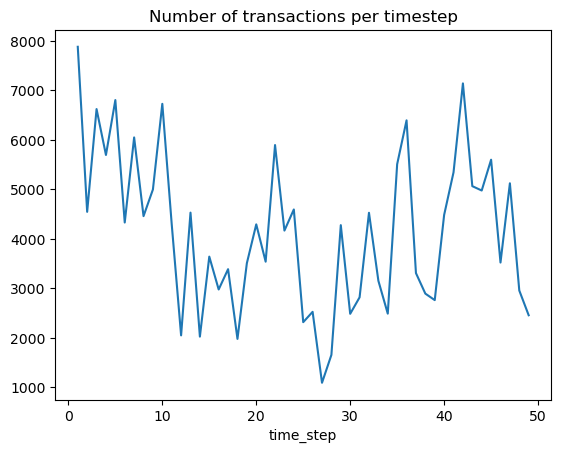

In [10]:
df_features['time_step'].value_counts().sort_index().plot()
plt.title('Number of transactions per timestep')
plt.show()

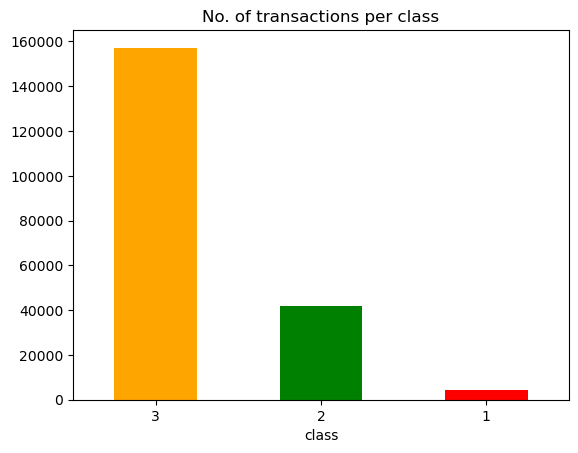

In [11]:
df_classes['class'].value_counts().plot(kind = 'bar', color = ['orange', 'green', 'red'])
plt.xticks(rotation = 0)
plt.title('No. of transactions per class')
plt.show()

In [12]:
df_class_feature = pd.merge(df_classes, df_features)
df_class_feature.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [13]:
group_class_feature = df_class_feature.groupby(['class', 'time_step'])['txId'].count().reset_index()
group_class_feature.columns = ['Class', 'Time Step', 'Transaction Count']
group_class_feature.head()

,Class,Time Step,Transaction Count
0,3,1,5733
1,3,2,3427
2,3,3,5342
3,3,4,4253
4,3,5,4921


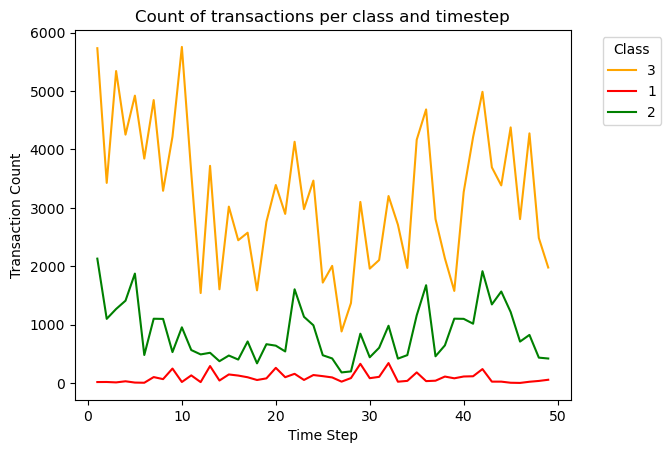

In [14]:
sns.lineplot(data = group_class_feature, x = 'Time Step', y = 'Transaction Count', hue = 'Class', palette = ['orange',
    'red', 'green'])
plt.title('Count of transactions per class and timestep')
plt.legend(title = 'Class', bbox_to_anchor=(1.05, 1), loc = 2)
plt.show()

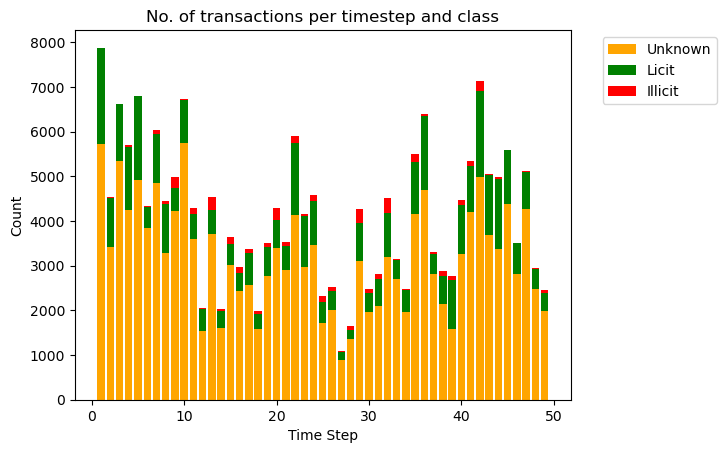

In [15]:
class1 = group_class_feature[group_class_feature['Class'] == '1']
class2 = group_class_feature[group_class_feature['Class'] == '2']
class3 = group_class_feature[group_class_feature['Class'] == 3]

p1 = plt.bar(class3['Time Step'], class3['Transaction Count'], color = 'orange')

p2 = plt.bar(class2['Time Step'], class2['Transaction Count'], color = 'green'
             , bottom = class3['Transaction Count'])

p3 = plt.bar(class1['Time Step'], class1['Transaction Count'], color = 'red'
             , bottom = np.array(class3['Transaction Count']) + np.array(class2['Transaction Count']))

plt.xlabel('Time Step')
plt.ylabel('Count')
plt.title('No. of transactions per timestep and class')
plt.legend(['Unknown', 'Licit', 'Illicit'], bbox_to_anchor = (1.05,1), loc = 2)
plt.show()

In [16]:
group_class_feature.groupby(['Class'])['Transaction Count'].max()

Class
3    5755
1     342
2    2130
Name: Transaction Count, dtype: int64

In [17]:
group_class_feature.loc[group_class_feature['Transaction Count'] == 342]

,Class,Time Step,Transaction Count
80,1,32,342


In [18]:
illicit_ids = df_class_feature.loc[(df_class_feature['time_step'] == 32) & (df_class_feature['class'] == '1'), 'txId']
illicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

In [19]:
illicit_edges.head()

,txId1,txId2
145842,355009662,91806025
145881,355003977,355238405
145913,355102230,355102228
145948,355998263,159817356
145982,355128718,355006712


In [20]:
#graph = nx.from_pandas_edgelist(illicit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())

#pos = nx.spring_layout(graph)
#nx.draw(graph, with_labels = False, pos = pos)

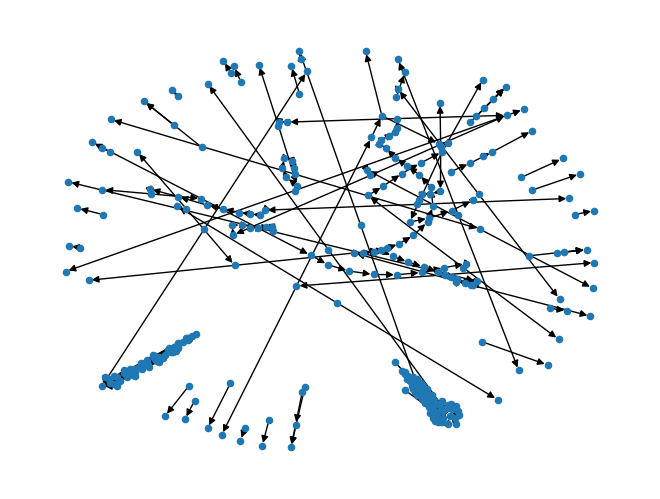

In [21]:
graph = nx.from_pandas_edgelist(illicit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels = False, pos = pos, node_size = 20)

> From the above graph it is noticeable that there is pattern of long transaction chain for most of the illicit transactions.

In [22]:
licit_ids = df_class_feature.loc[(df_class_feature['time_step'] == 32) & (df_class_feature['class'] == '2'), 'txId']
licit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(licit_ids)]

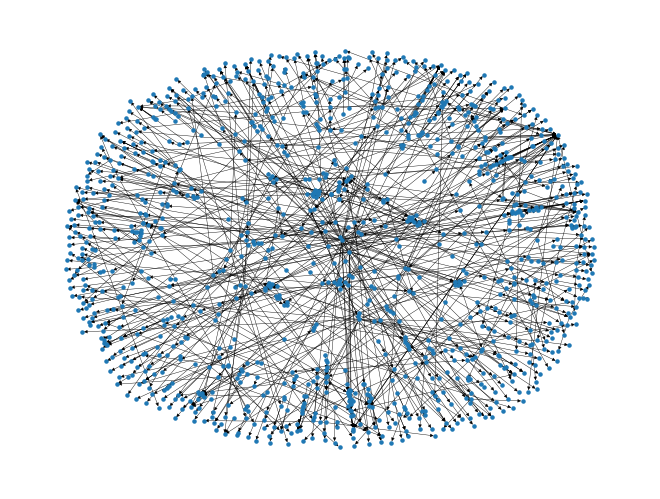

In [23]:
graph = nx.from_pandas_edgelist(licit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels = False, pos = pos, node_size = 5, width = 0.3, arrowsize = 5)

In [24]:
df_class_feature.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


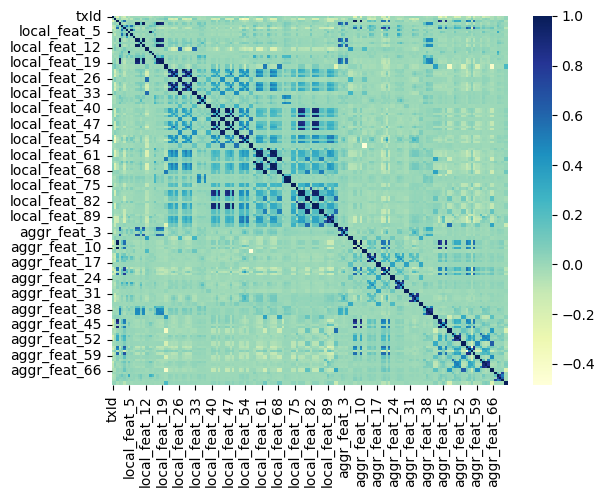

In [25]:
df_corr = df_class_feature.corr()

sns.heatmap(df_corr, cmap = 'YlGnBu')

plt.show()

<h3> Classification for class 1 and 2 transactions only </h3>

In [26]:
selected_ids = df_class_feature.loc[df_class_feature['class'] != 3, 'txId']

In [27]:
type(selected_ids)

pandas.core.series.Series

In [28]:
df_edges_selected = df_edgelist.loc[df_edgelist['txId1'].isin(selected_ids)]
df_classes_selected = df_classes.loc[df_classes['txId'].isin(selected_ids)]
df_features_selected = df_features.loc[df_features['txId'].isin(selected_ids)]

In [29]:
df_class_features_selected = pd.merge(df_classes_selected, df_features_selected)
df_class_features_selected.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,2,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,2,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,2,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [31]:
X = df_class_features_selected.drop(columns = ['txId', 'class', 'time_step'])
y = df_class_features_selected[['class']]
y = y['class'].apply(lambda x:0 if x == '2' else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0
                                                    , stratify = y, shuffle = True)

In [32]:
X_train.shape, X_test.shape

((34923, 165), (11641, 165))

In [33]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pc_feature_names = [f"feature {i+1}" for i in range(X_train.shape[1])]

In [34]:
pca = PCA(n_components = 59)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

In [35]:
sum(explained_variance)

0.954368404551283

In [36]:
component_weights = pca.components_

In [ ]:
feature_weights_mapping = {}

for i, component in enumerate(component_weights):
    component_feature_weights = zip(pc_feature_names, component)
    feature_weights_mapping[f"Component {i+1}"] = sorted(component_feature_weights,
                                                        key = lambda x: abs(x[1]), reverse = True)

In [ ]:
feature_weights_mapping['Component 3']

## Logistic Regression Classifier:

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

classifier = LogisticRegression(random_state = 0, max_iter = 1000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [38]:
y_pred_logistic = classifier.predict(X_test)
y_pred_logistic

array([0, 1, 0, ..., 0, 0, 0])

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
cm_logistic = confusion_matrix(y_test, y_pred_logistic)

cm_logistic

array([[10311,   194],
       [  390,   746]])

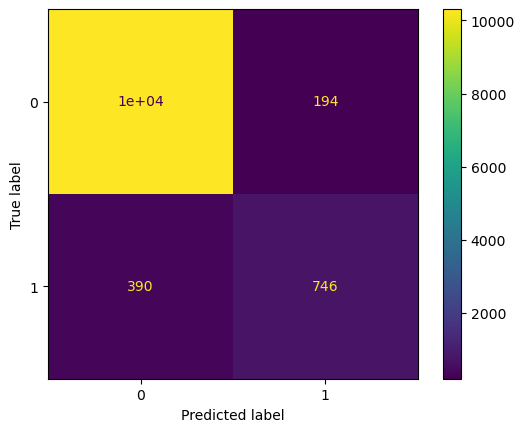

In [41]:
cm_logistic_display = ConfusionMatrixDisplay(cm_logistic, display_labels = classifier.classes_)
cm_logistic_display.plot()
plt.show()

In [42]:
precision_lr, recall_lr, f1_lr, num_lr = precision_recall_fscore_support(y_test.values, y_pred_logistic)

print("*"*28)
print("Logistic Regression Results:")
print("*"*28, '\n')
print(f"Precision: {precision_lr[1]}, Recall: {recall_lr[1]} & F1 Score: {f1_lr[1]}.")

****************************
Logistic Regression Results:
**************************** 

Precision: 0.7936170212765957, Recall: 0.6566901408450704 & F1 Score: 0.7186897880539498.


In [57]:
accuracy_lr = accuracy_score(y_test, y_pred_logistic)
print(f"The accuracy of Logistic Regression model is {accuracy_lr}.")

The accuracy of Logistic Regression model is 0.9498324886178163.


## Random Forest Classifier:

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rf_classifier = RandomForestClassifier(random_state = 0, criterion = 'entropy', verbose = 0)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)
y_pred_rf

array([0, 1, 0, ..., 0, 0, 0])

In [46]:
rf_classifier.score(X_test, y_test)

0.9737995017610171

In [47]:
cm_randomforest = confusion_matrix(y_test, y_pred_rf)
cm_randomforest

array([[10475,    30],
       [  275,   861]])

In [48]:
precision_rf, recall_rf, f1_rf, num_rf = precision_recall_fscore_support(y_test, y_pred_rf)

print("*"*20)
print("Random Forest Results:")
print("*"*20, '\n')
print(f"Precision: {precision_rf[1]}, Recall: {recall_rf[1]} & F1 Score: {f1_rf[1]}.")

********************
Random Forest Results:
******************** 

Precision: 0.9663299663299664, Recall: 0.7579225352112676 & F1 Score: 0.8495313270843612.


In [58]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"The accuracy of Random Forest Classifier model is {accuracy_rf}.")

The accuracy of Random Forest Classifier model is 0.9737995017610171.


## Gradient Boosting Classifier:

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

In [51]:
gb_classifier = GradientBoostingClassifier(random_state = 0, learning_rate = 0.1)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [52]:
gb_classifier.score(X_test, y_test)

0.9668413366549266

In [53]:
y_pred_gb = gb_classifier.predict(X_test)
y_pred_gb

array([0, 1, 0, ..., 0, 0, 0])

In [54]:
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_gb

array([[10433,    72],
       [  314,   822]])

In [55]:
precision_gb, recall_gb, fscore_gb, num_gb = precision_recall_fscore_support(y_test, y_pred_gb)

print("*"*25)
print("Gradient Boosting Results:")
print("*"*25, '\n')
print(f"Precision: {precision_gb[1]}, Recall: {recall_gb[1]} & F1 Score: {fscore_gb[1]}.")

*************************
Gradient Boosting Results:
************************* 

Precision: 0.9194630872483222, Recall: 0.7235915492957746 & F1 Score: 0.8098522167487685.


In [56]:
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"The accuracy of Gradient Boosing model is {accuracy_gb}.")

The accuracy of Gradient Boosing model is 0.9668413366549266.


> As Random Forest Classifier has outperformed the other models for this problem. We predict the unknown records using this model next.

### Predict the Unknown Transactions

In [59]:
df_class_feature.head()
#df_class_feature['class'].value_counts()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [60]:
unknown_ids = df_class_feature.loc[df_class_feature['class'] == 3, ['txId']]

In [61]:
df_final_edgelist = df_edgelist.loc[df_edgelist['txId1'].isin(unknown_ids.squeeze())]
df_final_classes = df_classes.loc[df_classes['txId'].isin(unknown_ids.squeeze())]
df_final_features = df_features.loc[df_features['txId'].isin(unknown_ids.squeeze())]

In [62]:
df_final_class_feature = pd.merge(df_final_classes, df_final_features)

df_final_class_feature.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,3,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [63]:
X_unknown = df_final_class_feature.drop(columns = ['txId', 'class', 'time_step'])
y_unknown = df_final_class_feature[['class']]

In [66]:
X_unknown = sc.fit_transform(X_unknown)

In [67]:
pc_feature_names = [f"feature {i+1}" for i in range(X_unknown.shape[1])]

pca = PCA(n_components = 59)

X_unknown = pca.fit_transform(X_unknown)

explained_variance = pca.explained_variance_ratio_

sum(explained_variance)

0.9572143174304574

In [68]:
component_weights = pca.components_

In [84]:
y_pred_unknown = rf_classifier.predict(X_unknown)
y_pred_unknown

array([0, 0, 0, ..., 0, 0, 0])

In [87]:
df_final_classes = df_final_classes.copy()
df_final_classes.loc[:, 'class'] = y_pred_unknown

In [89]:
df_final_unknown = pd.merge(df_final_classes, df_final_features)
df_final_unknown.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,0,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


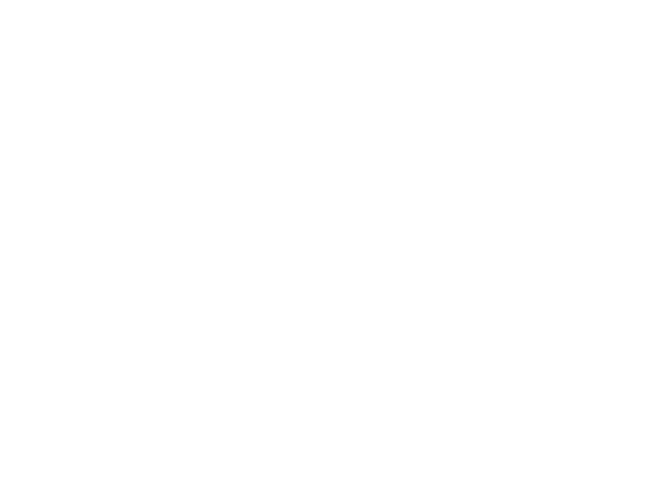

In [93]:
illicit_ids = df_final_unknown.loc[(df_final_unknown['time_step'] == 32) & (df_final_unknown['class'] == 1), 'txId']
illicit_edges = df_final_edgelist.loc[df_final_edgelist['txId1'].isin(illicit_ids)]

graph = nx.from_pandas_edgelist(illicit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)

## PCA by methods:

In [ ]:
X_mean = X.mean()

X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std

In [ ]:
covariance_mat = Z.cov()

plt.figure(figsize = (25,25))

sns.heatmap(covariance_mat, cmap = 'YlGnBu')
plt.show()

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_mat)
print('Eigen Values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

In [ ]:
# Index the eigenvalues in descending order
idx = eigenvalues.argsort()[::-1]

# Sort the eigenvalues in descending order
eigenvalues = eigenvalues[idx]

# Sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]

In [ ]:
explained_var = np.cumsum(eigenvalues)/ np.sum(eigenvalues)
explained_var

In [ ]:
plt.plot(explained_var)
plt.xlabel('No. of Components')
plt.ylabel('Explained Variance')
plt.show()

In [ ]:
# Selecting numbers components which explains more than 95% of the variance in the data

n_components = np.argmax(explained_var >= 0.95) + 1
n_components